In [5]:
#This is the Final Project of the Online Machine Learning Udemy Course.
#Developed by Polydoros Akritidis

# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [6]:
# Importing Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


#Read the data and convert the ? to Na Values
df = pd.read_csv("mammographic_masses.data.txt",na_values=["?"], names=["BI_RADS", "age", "shape", "margin", "density", "severity"] )

df.head()


,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [7]:
#already done this at the previous question

Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [8]:
#Take a look at the data 
df.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [9]:
df.loc[(df['age'].isnull()) |
              (df['shape'].isnull()) |
              (df['margin'].isnull()) |
              (df['density'].isnull())]

,BI_RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [10]:
#Since the missing data is randomly distributed we can drop them
df.dropna(inplace=True)
df.describe()

,BI_RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [11]:
feature_data = df.loc[:,['age','shape','margin', 'density']]
class_data = df.loc[:,['severity']]

feature_names = ['age', 'shape', 'margin', 'density']
feature_data.head() 
class_data.head()

,severity
0,1
2,1
3,0
8,1
10,1


Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [12]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
feature_data_scaled=scaler.fit_transform(feature_data)
feature_data_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [13]:
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_data_scaled, class_data, test_size=0.25, random_state=0)

Now create a DecisionTreeClassifier and fit it to your training data.

In [14]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

Display the resulting decision tree.

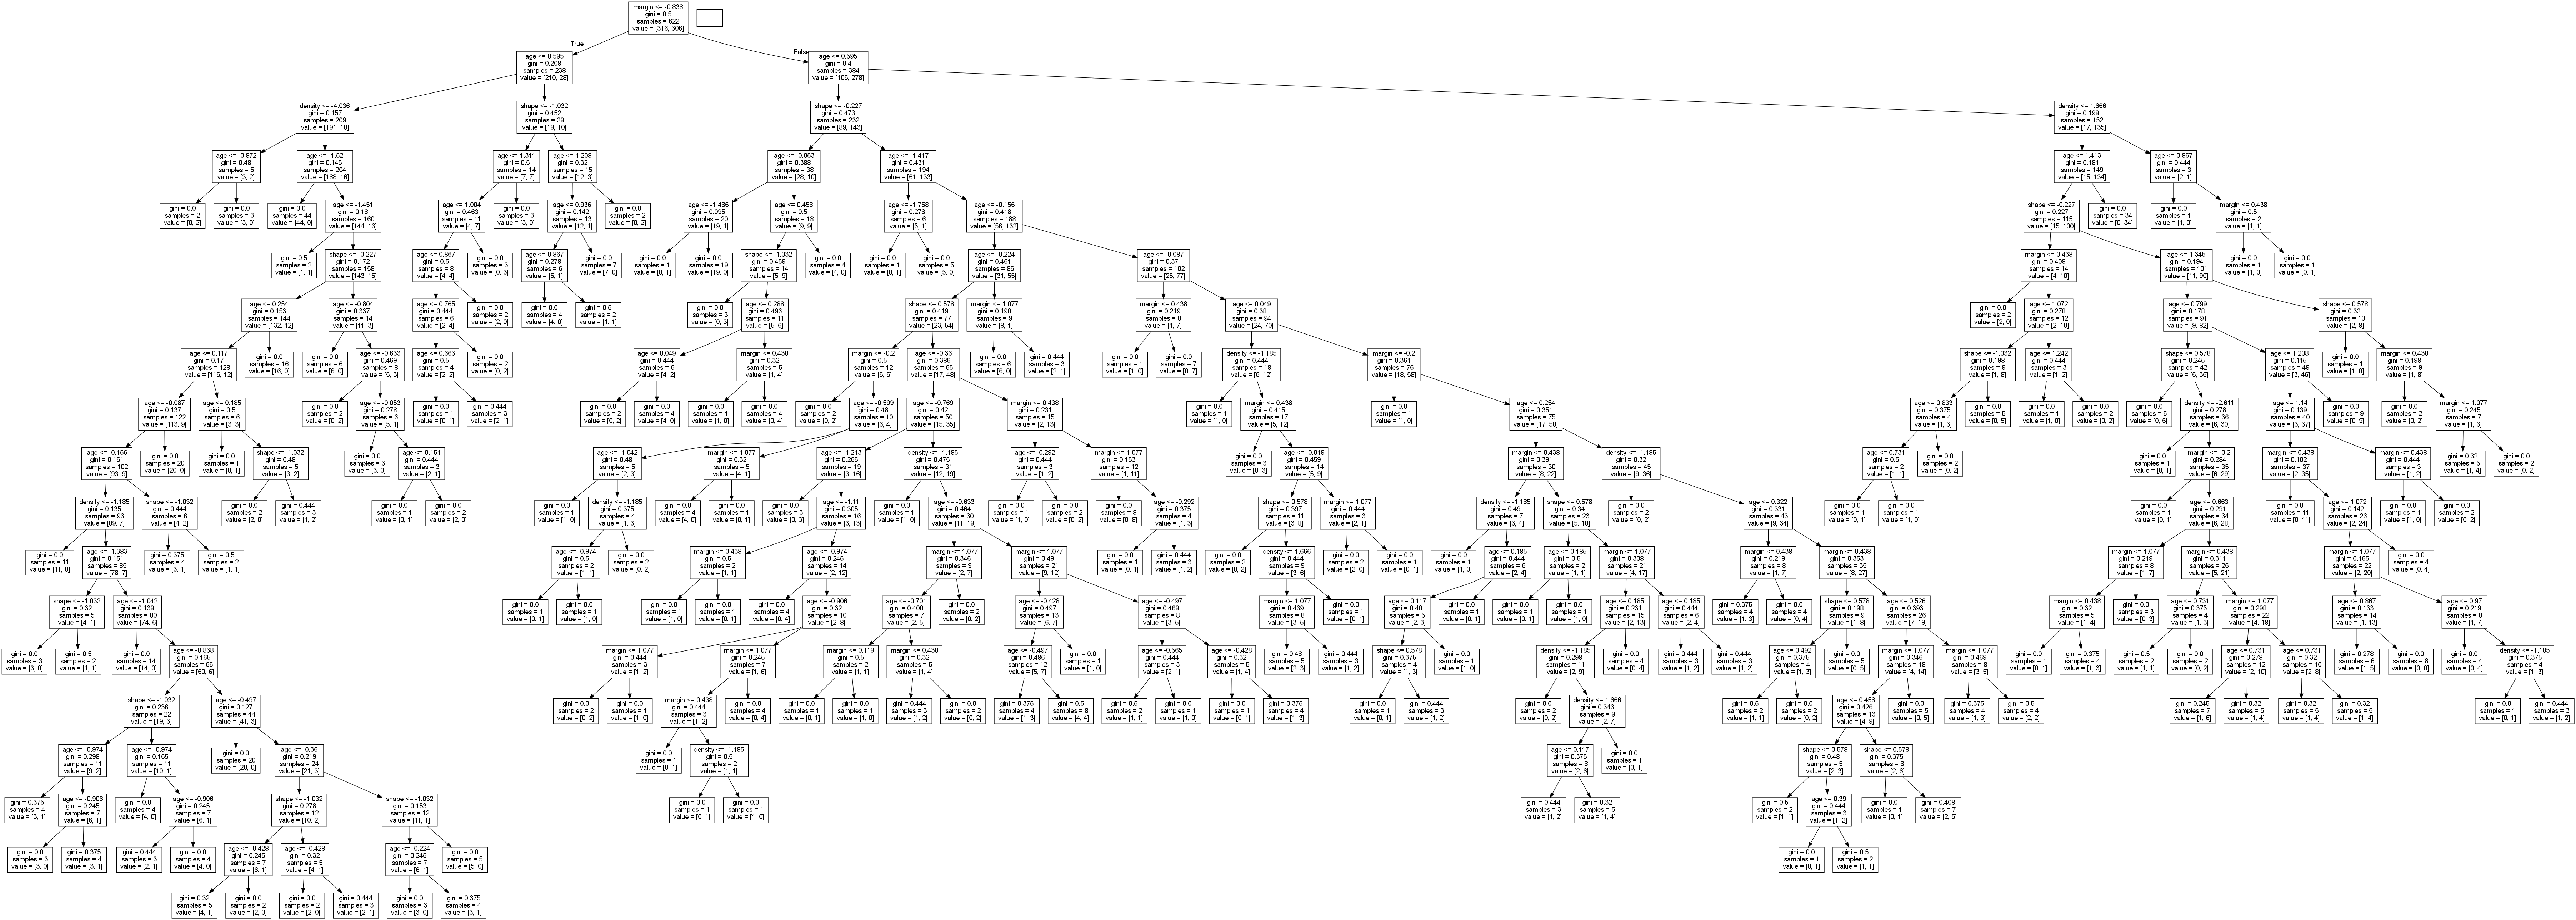

In [15]:
from IPython.display import Image  
from six import StringIO  
from sklearn import tree
from pydotplus import graph_from_dot_data 

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_names)  
graph = graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Measure the accuracy of the resulting decision tree model using your test data.

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, clf.predict(X_test))

0.7163461538461539

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [17]:
scores = cross_val_score(clf, feature_data_scaled, class_data , cv=10)

print("Kfold Tree Accuracy and mean ")
print(scores)
print(scores.mean())

Kfold Tree Accuracy and mean 
[0.73493976 0.75903614 0.72289157 0.75903614 0.77108434 0.69879518
 0.73493976 0.74698795 0.74698795 0.68674699]
0.736144578313253


Now try a RandomForestClassifier instead. Does it perform better?

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10,random_state=1)

scores = cross_val_score(clf, feature_data_scaled, class_data , cv=10)
print("Forest Accuracy and mean ")
#print(scores)
print(scores.mean())


Forest Accuracy and mean 
0.7421686746987952


## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [19]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, feature_data_scaled, class_data , cv=10)
print ("SVM Score")
#print(scores)
print(scores.mean())


SVM Score
0.7975903614457832


## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier (n_neighbors=10)
scores = cross_val_score(clf, feature_data_scaled, class_data , cv=10)
print ("KNN Score for K=10")
#print(scores)
print(scores.mean())

KNN Score for K=10
0.7927710843373494


Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [21]:
print ("Checking from 1 to 50 neighbours")
for x in range(50):
    clf = KNeighborsClassifier (n_neighbors=x+1)
    scores = cross_val_score(clf, feature_data_scaled, class_data , cv=10)
    print ("KNN Score for K= ",(x+1),scores.mean())
    #print(scores)
    #print(scores.mean())

Checking from 1 to 50 neighbours
KNN Score for K=  1 0.7228915662650601
KNN Score for K=  2 0.6855421686746987
KNN Score for K=  3 0.7530120481927711
KNN Score for K=  4 0.7385542168674699
KNN Score for K=  5 0.7783132530120482
KNN Score for K=  6 0.7650602409638554
KNN Score for K=  7 0.7975903614457832
KNN Score for K=  8 0.7819277108433734
KNN Score for K=  9 0.7927710843373493
KNN Score for K=  10 0.7927710843373494
KNN Score for K=  11 0.7951807228915662
KNN Score for K=  12 0.7843373493975905
KNN Score for K=  13 0.7843373493975904
KNN Score for K=  14 0.7855421686746988
KNN Score for K=  15 0.7855421686746988
KNN Score for K=  16 0.7831325301204819
KNN Score for K=  17 0.7867469879518072
KNN Score for K=  18 0.7783132530120482
KNN Score for K=  19 0.7855421686746988
KNN Score for K=  20 0.7843373493975904
KNN Score for K=  21 0.7867469879518072
KNN Score for K=  22 0.783132530120482
KNN Score for K=  23 0.7795180722891566
KNN Score for K=  24 0.7771084337349399
KNN Score for K= 

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

clf = MultinomialNB()

min_max=MinMaxScaler()
feature_data_scaled_minmax=min_max.fit_transform(feature_data)
scores = cross_val_score(clf, feature_data_scaled_minmax, class_data , cv=10)

print("Multinomial Naive Bayes")
#print(scores)
print(scores.mean())

Multinomial Naive Bayes
0.7855421686746988


## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [23]:
clf = svm.SVC(kernel='poly', C=1)
scores = cross_val_score(clf, feature_data_scaled, class_data , cv=10)
print ("SVM Score poly")
#print(scores)
print(scores.mean())

SVM Score poly
0.7903614457831326


In [24]:
clf = svm.SVC(kernel='sigmoid', C=1)
scores = cross_val_score(clf, feature_data_scaled, class_data , cv=10)
print ("SVM Score sigmoid")
#print(scores)
print(scores.mean())

SVM Score sigmoid
0.7457831325301204


In [25]:
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, feature_data_scaled, class_data , cv=10)
print ("SVM Score RBF")
#print(scores)
print(scores.mean())

SVM Score RBF
0.8012048192771084


## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [26]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
scores = cross_val_score(clf, feature_data_scaled, class_data , cv=10)
print ("Logistic Regression")
#print(scores)
print(scores.mean())

Logistic Regression
0.8072289156626505


## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [27]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    #4 feature inputs going into an 6-unit layer (more does not seem to help - in fact you can go down to 4)
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    # "Deep learning" turns out to be unnecessary - this additional hidden layer doesn't help either.
    #model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    # Output layer with a binary classification (benign or malignant)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model; adam seemed to work best
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [28]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Wrap our Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
# Now we can use scikit_learn's cross_val_score to evaluate this model identically to the others
scores = cross_val_score(estimator, feature_data_scaled,class_data, cv=10)

scores.mean()

0.8024096369743348

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!